# Setup

**Imports**

In [73]:
import datetime as dt
from math import log
import IPython
import geopandas
import contextily as cx
from math import asin, cos, radians, sin, sqrt


from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.fft import fft
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform
from scipy.signal import stft
from sklearn.cluster import KMeans

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [74]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

STFT shape: (451, 45)
Energy per frequency shape: (451,)
Frequency bins: 451, Time frames: 45


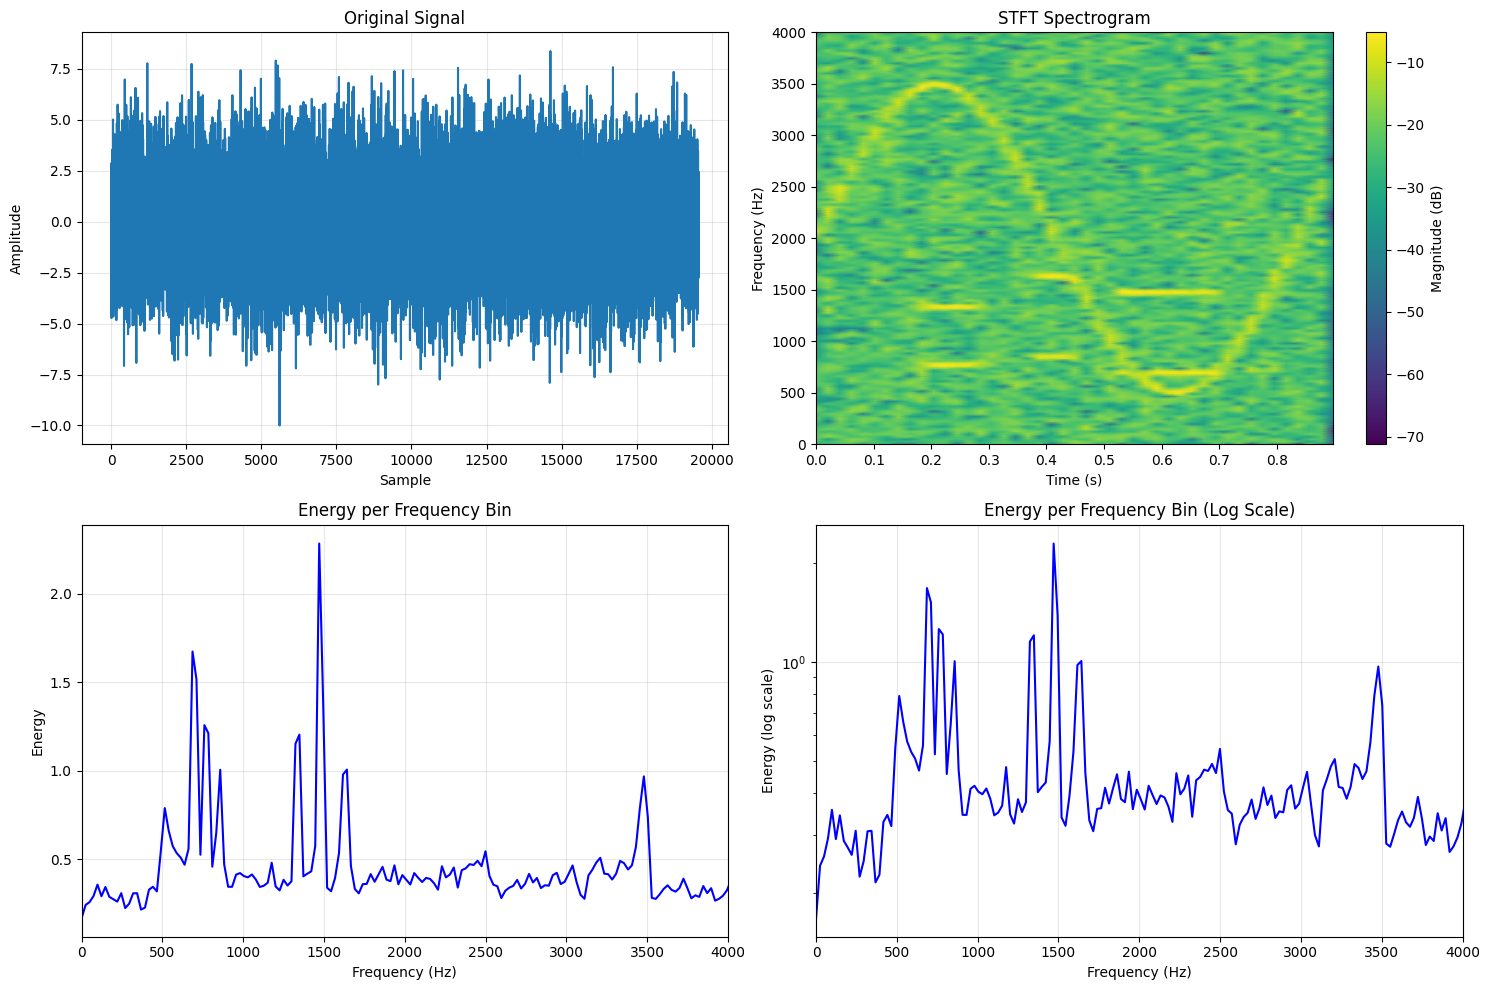

In [75]:
# Cell 1: STFT and energy computation
# we compute the STFT to obtain the time-frequency representation
# for each frequency bin, we compute the energy by integrating over the time axis

signal = X_train[0]  # example signal
window_length = 900
overlap = window_length // 2

# compute STFT
f, t, Zxx = stft(signal, fs=FS, nperseg=window_length, noverlap=overlap)

# compute energy for each frequency bin by integrating over time
energy_per_freq = np.sum(np.abs(Zxx)**2, axis=1)  # shape: (n_freq,)

print(f"STFT shape: {Zxx.shape}")
print(f"Energy per frequency shape: {energy_per_freq.shape}")
print(f"Frequency bins: {len(f)}, Time frames: {len(t)}")

# visualization: STFT spectrogram and energy distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# plot 1: original signal
axes[0, 0].plot(signal)
axes[0, 0].set_title("Original Signal")
axes[0, 0].set_xlabel("Sample")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].grid(True, alpha=0.3)

# plot 2: STFT spectrogram
spectrogram = np.abs(Zxx)
im1 = axes[0, 1].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                            shading='gouraud', cmap='viridis')
axes[0, 1].set_title("STFT Spectrogram")
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Frequency (Hz)")
axes[0, 1].set_ylim([0, 4000])  # focus on DTMF frequency range
plt.colorbar(im1, ax=axes[0, 1], label="Magnitude (dB)")

# plot 3: energy per frequency bin
axes[1, 0].plot(f, energy_per_freq, 'b-', linewidth=1.5)
axes[1, 0].set_title("Energy per Frequency Bin")
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Energy")
axes[1, 0].set_xlim([0, 4000])
axes[1, 0].grid(True, alpha=0.3)

# plot 4: energy per frequency (log scale)
axes[1, 1].semilogy(f, energy_per_freq, 'b-', linewidth=1.5)
axes[1, 1].set_title("Energy per Frequency Bin (Log Scale)")
axes[1, 1].set_xlabel("Frequency (Hz)")
axes[1, 1].set_ylabel("Energy (log scale)")
axes[1, 1].set_xlim([0, 4000])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Total frequency bins: 451
High-energy (signal) bins: 12
Noise bins: 439
Signal cluster center energy: 1.30e+00
Noise cluster center energy: 3.30e-01


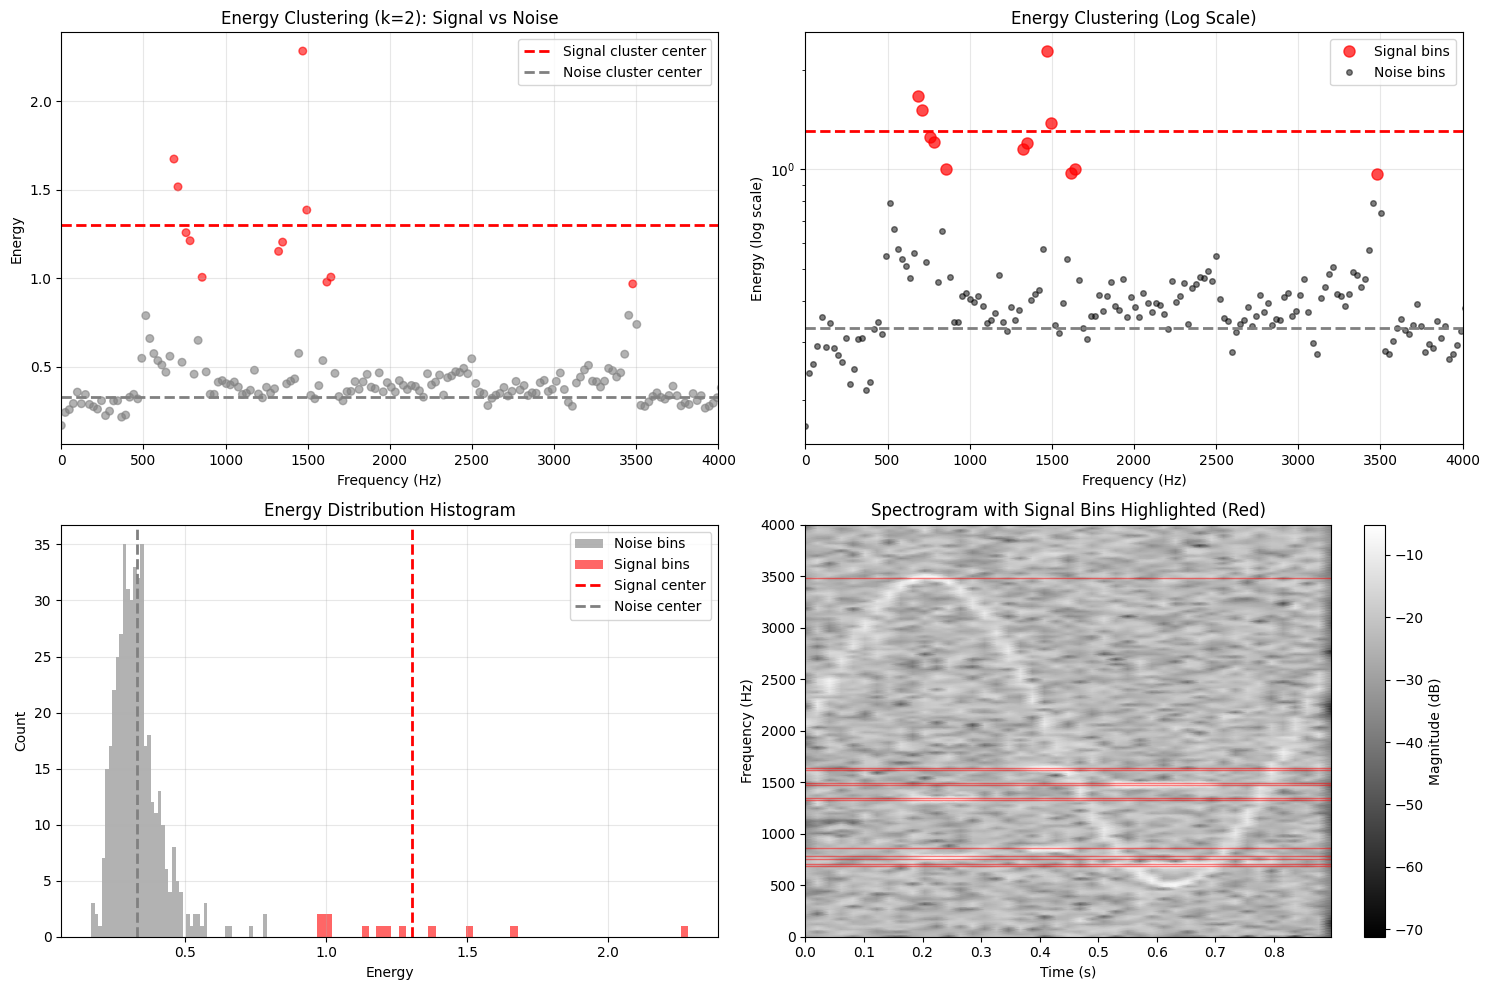

In [76]:
# Cell 2: First k-means (k=2) to separate signal from noise
# we perform k-means clustering on the energy values to separate frequency bins 
# with high energy (signal) from those with low energy (noise)

# reshape energy for k-means
energy_reshaped = energy_per_freq.reshape(-1, 1)

# k-means with k=2 to separate signal from noise
kmeans_energy = KMeans(n_clusters=2, random_state=0, n_init=10)
energy_labels = kmeans_energy.fit_predict(energy_reshaped)

# identify which cluster has higher energy (signal cluster)
cluster_centers = kmeans_energy.cluster_centers_.flatten()
signal_cluster_idx = np.argmax(cluster_centers)
noise_cluster_idx = 1 - signal_cluster_idx

# get frequency bins that belong to signal cluster
high_energy_freq_indices = np.where(energy_labels == signal_cluster_idx)[0]
high_energy_freqs = f[high_energy_freq_indices]

print(f"Total frequency bins: {len(f)}")
print(f"High-energy (signal) bins: {len(high_energy_freq_indices)}")
print(f"Noise bins: {len(f) - len(high_energy_freq_indices)}")
print(f"Signal cluster center energy: {cluster_centers[signal_cluster_idx]:.2e}")
print(f"Noise cluster center energy: {cluster_centers[noise_cluster_idx]:.2e}")

# visualization: energy clustering results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# plot 1: energy distribution with cluster assignment
colors = ['red' if label == signal_cluster_idx else 'gray' 
          for label in energy_labels]
axes[0, 0].scatter(f, energy_per_freq, c=colors, alpha=0.6, s=30)
axes[0, 0].axhline(y=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2, label='Signal cluster center')
axes[0, 0].axhline(y=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2, label='Noise cluster center')
axes[0, 0].set_title("Energy Clustering (k=2): Signal vs Noise")
axes[0, 0].set_xlabel("Frequency (Hz)")
axes[0, 0].set_ylabel("Energy")
axes[0, 0].set_xlim([0, 4000])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# plot 2: energy distribution (log scale) with clusters
axes[0, 1].semilogy(f[energy_labels == signal_cluster_idx], 
                    energy_per_freq[energy_labels == signal_cluster_idx], 
                    'ro', markersize=8, alpha=0.7, label='Signal bins')
axes[0, 1].semilogy(f[energy_labels == noise_cluster_idx], 
                    energy_per_freq[energy_labels == noise_cluster_idx], 
                    'ko', markersize=4, alpha=0.5, label='Noise bins')
axes[0, 1].axhline(y=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2)
axes[0, 1].axhline(y=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2)
axes[0, 1].set_title("Energy Clustering (Log Scale)")
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Energy (log scale)")
axes[0, 1].set_xlim([0, 4000])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# plot 3: histogram of energy values with cluster centers
axes[1, 0].hist(energy_per_freq[energy_labels == noise_cluster_idx], 
                bins=50, alpha=0.6, color='gray', label='Noise bins')
axes[1, 0].hist(energy_per_freq[energy_labels == signal_cluster_idx], 
                bins=50, alpha=0.6, color='red', label='Signal bins')
axes[1, 0].axvline(x=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2, label='Signal center')
axes[1, 0].axvline(x=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2, label='Noise center')
axes[1, 0].set_title("Energy Distribution Histogram")
axes[1, 0].set_xlabel("Energy")
axes[1, 0].set_ylabel("Count")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# plot 4: spectrogram highlighting signal vs noise bins
spectrogram = np.abs(Zxx)
im = axes[1, 1].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                           shading='gouraud', cmap='gray')
# highlight signal bins
for idx in high_energy_freq_indices:
    axes[1, 1].axhline(y=f[idx], color='red', linewidth=1, alpha=0.5)
axes[1, 1].set_title("Spectrogram with Signal Bins Highlighted (Red)")
axes[1, 1].set_xlabel("Time (s)")
axes[1, 1].set_ylabel("Frequency (Hz)")
axes[1, 1].set_ylim([0, 4000])
plt.colorbar(im, ax=axes[1, 1], label="Magnitude (dB)")

plt.tight_layout()
plt.show()

Number of major frequency clusters (after filtering): 7
Cluster 0: center=698.2 Hz, energy=1.60e+00, n_bins=2
Cluster 1: center=771.7 Hz, energy=1.23e+00, n_bins=2
Cluster 2: center=857.5 Hz, energy=1.01e+00, n_bins=1
Cluster 3: center=1335.2 Hz, energy=1.18e+00, n_bins=2
Cluster 4: center=1470.0 Hz, energy=2.28e+00, n_bins=1
Cluster 5: center=1494.5 Hz, energy=1.39e+00, n_bins=1
Cluster 6: center=1629.2 Hz, energy=9.92e-01, n_bins=2


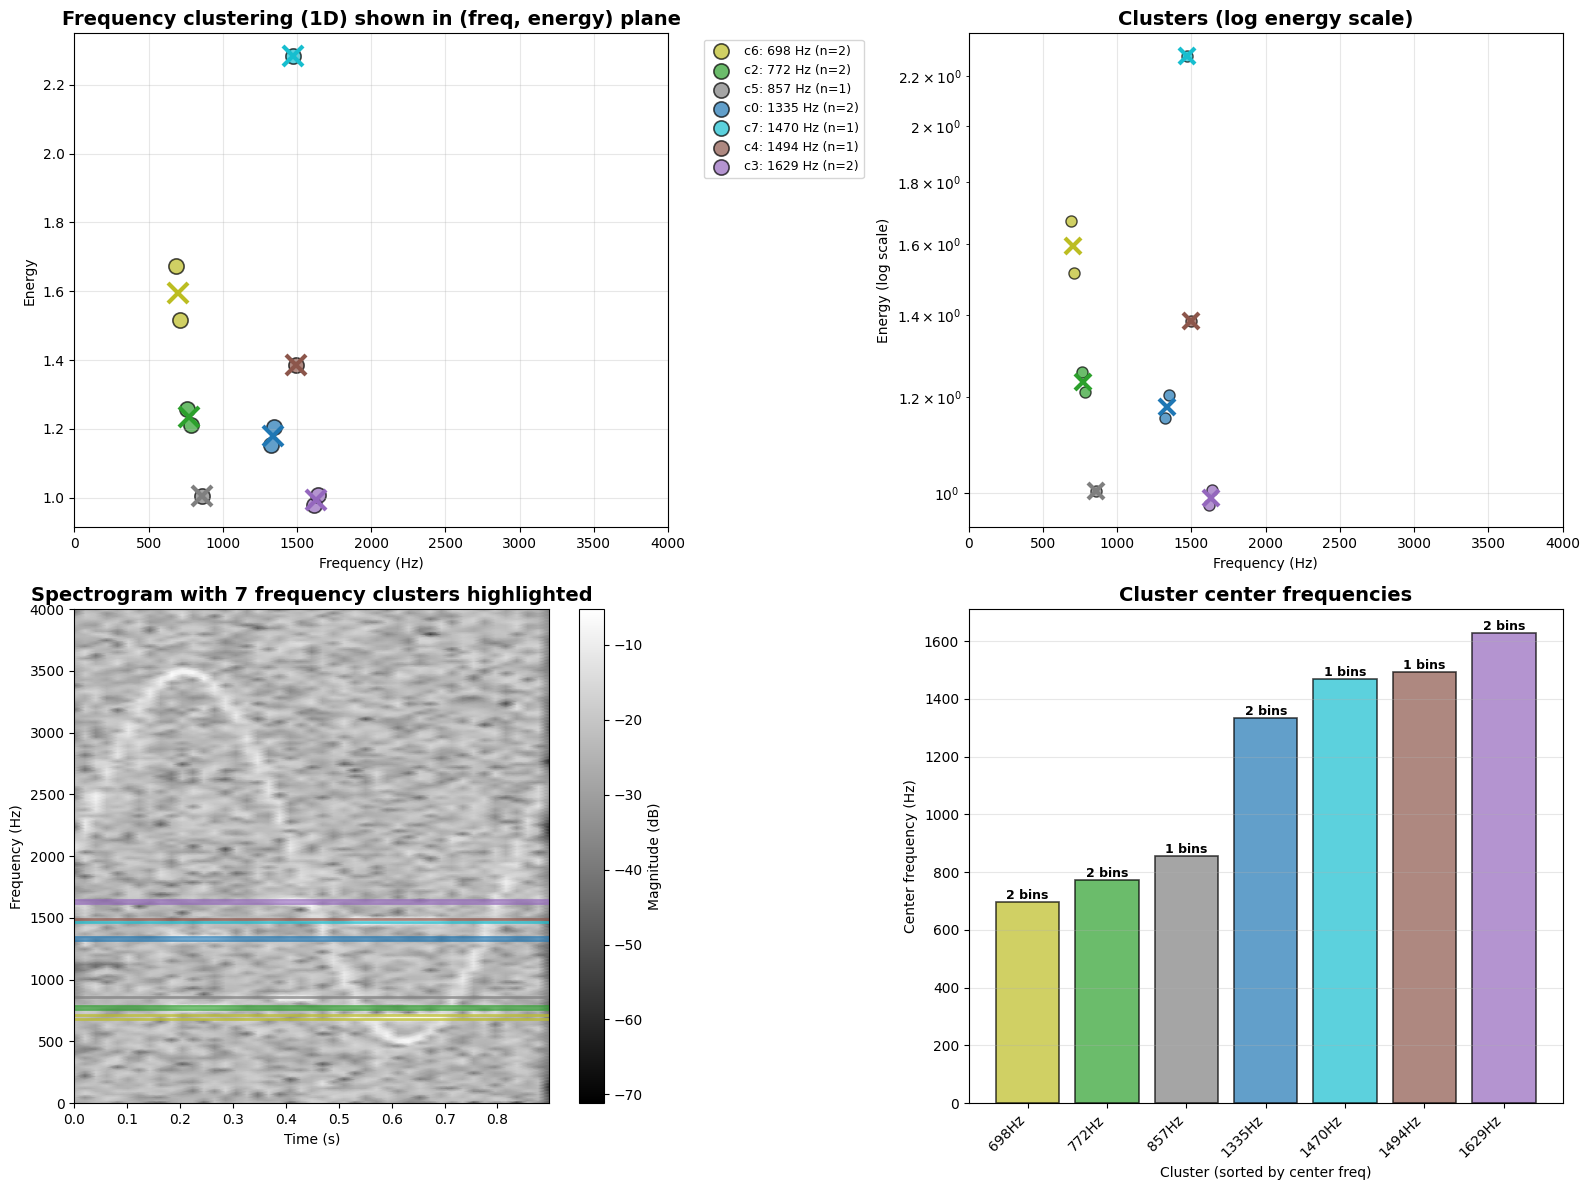

In [77]:
# Cell 3: Second k-means (k=8) to group frequency bins into DTMF frequency bands
# within the high-energy frequency bins, multiple bins may correspond to the same
# DTMF frequency due to spectral leakage. we cluster in 1d on frequency only
# (we do NOT drop singleton clusters, otherwise we may lose tones)

# get frequency and energy values of high-energy bins
high_energy_freqs = f[high_energy_freq_indices]
high_energy_energies = energy_per_freq[high_energy_freq_indices]

n_high_energy = len(high_energy_freq_indices)
k_freq_eff = min(8, max(1, n_high_energy))

if n_high_energy < 2:
    print(f"Warning: only {n_high_energy} high-energy bins; skipping frequency clustering")
    major_freq_clusters = []
    freq_cluster_labels = None
else:
    # 1d features: normalized frequency only
    freq_norm = (high_energy_freqs - high_energy_freqs.min()) / (high_energy_freqs.max() - high_energy_freqs.min() + 1e-10)
    freqs_1d = freq_norm.reshape(-1, 1)

    kmeans_freq = KMeans(n_clusters=k_freq_eff, random_state=0, n_init=10)
    freq_cluster_labels = kmeans_freq.fit_predict(freqs_1d)

    # build clusters (we keep singleton clusters)
    major_freq_clusters = []
    for cluster_id in range(k_freq_eff):
        cluster_mask = freq_cluster_labels == cluster_id
        cluster_freq_indices = high_energy_freq_indices[cluster_mask]
        cluster_freqs = high_energy_freqs[cluster_mask]
        cluster_energies = high_energy_energies[cluster_mask]

        cluster_center_freq = np.mean(cluster_freqs)
        cluster_center_energy = np.mean(cluster_energies)

        major_freq_clusters.append({
            'cluster_id': cluster_id,
            'center_freq': cluster_center_freq,
            'center_energy': cluster_center_energy,
            'freq_indices': cluster_freq_indices,
            'freqs': cluster_freqs,
            'energies': cluster_energies
        })

# filter out extreme outliers, but keep a wide margin
dtmf_freq_range = (400, 2000)
major_freq_clusters = [c for c in major_freq_clusters if dtmf_freq_range[0] <= c['center_freq'] <= dtmf_freq_range[1]]

# sort by center frequency
major_freq_clusters.sort(key=lambda x: x['center_freq'])

print(f"Number of major frequency clusters (after filtering): {len(major_freq_clusters)}")
for i, cluster in enumerate(major_freq_clusters):
    print(f"Cluster {i}: center={cluster['center_freq']:.1f} Hz, energy={cluster['center_energy']:.2e}, n_bins={len(cluster['freq_indices'])}")

# visualization: clustering diagnostics
n_clusters = len(major_freq_clusters)
colors_clusters = plt.cm.tab10(np.linspace(0, 1, max(1, k_freq_eff)))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1: frequency-energy scatter colored by cluster
if (freq_cluster_labels is not None) and (n_clusters > 0):
    for cluster in major_freq_clusters:
        cid = int(cluster['cluster_id'])
        axes[0, 0].scatter(cluster['freqs'], cluster['energies'],
                           c=[colors_clusters[cid]], s=120, alpha=0.7,
                           edgecolors='black', linewidths=1.2,
                           label=f"c{cid}: {cluster['center_freq']:.0f} Hz (n={len(cluster['freq_indices'])})")
        axes[0, 0].plot(cluster['center_freq'], cluster['center_energy'],
                        'x', color=colors_clusters[cid], markersize=14, markeredgewidth=3)
else:
    axes[0, 0].text(0.5, 0.5, 'no clusters to plot', ha='center', va='center', transform=axes[0, 0].transAxes)

axes[0, 0].set_title('Frequency clustering (1D) shown in (freq, energy) plane', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Energy')
axes[0, 0].set_xlim([0, 4000])
axes[0, 0].grid(True, alpha=0.3)
if n_clusters > 0:
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# plot 2: log-energy scatter
if (freq_cluster_labels is not None) and (n_clusters > 0):
    for cluster in major_freq_clusters:
        cid = int(cluster['cluster_id'])
        axes[0, 1].semilogy(cluster['freqs'], cluster['energies'],
                            'o', color=colors_clusters[cid], markersize=8, alpha=0.7,
                            markeredgecolor='black', markeredgewidth=1.0)
        axes[0, 1].semilogy(cluster['center_freq'], cluster['center_energy'],
                            'x', color=colors_clusters[cid], markersize=12, markeredgewidth=3)
else:
    axes[0, 1].text(0.5, 0.5, 'no clusters to plot', ha='center', va='center', transform=axes[0, 1].transAxes)

axes[0, 1].set_title('Clusters (log energy scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Energy (log scale)')
axes[0, 1].set_xlim([0, 4000])
axes[0, 1].grid(True, alpha=0.3)

# plot 3: spectrogram with clustered bins highlighted
spectrogram = np.abs(Zxx)
im = axes[1, 0].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), shading='gouraud', cmap='gray')
if n_clusters > 0:
    for cluster in major_freq_clusters:
        cid = int(cluster['cluster_id'])
        for idx in cluster['freq_indices']:
            axes[1, 0].axhline(y=f[idx], color=colors_clusters[cid], linewidth=2.0, alpha=0.7)

axes[1, 0].set_title(f'Spectrogram with {n_clusters} frequency clusters highlighted', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Frequency (Hz)')
axes[1, 0].set_ylim([0, 4000])
plt.colorbar(im, ax=axes[1, 0], label='Magnitude (dB)')

# plot 4: cluster centers bar chart
if n_clusters > 0:
    cluster_centers_freq = [c['center_freq'] for c in major_freq_clusters]
    cluster_sizes = [len(c['freq_indices']) for c in major_freq_clusters]
    bars = axes[1, 1].bar(range(n_clusters), cluster_centers_freq,
                          color=[colors_clusters[int(c['cluster_id'])] for c in major_freq_clusters],
                          alpha=0.7, edgecolor='black', linewidth=1.2)
    axes[1, 1].set_title('Cluster center frequencies', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Cluster (sorted by center freq)')
    axes[1, 1].set_ylabel('Center frequency (Hz)')
    axes[1, 1].set_xticks(range(n_clusters))
    axes[1, 1].set_xticklabels([f"{c:.0f}Hz" for c in cluster_centers_freq], rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    for bar, size in zip(bars, cluster_sizes):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(), f"{size} bins",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


Elbow candidates k=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Elbow inertias=[6486301.5, 1529982.682, 105343.875, 40516.875, 18907.875, 6402.667, 1500.625, 1200.5, 900.375, 600.25, 300.125, 0.0]
Selected k_opt=3
Number of major frequency clusters: 2
Cluster 0: center=759.5 Hz, n_bins=5
Cluster 1: center=1482.2 Hz, n_bins=6


/tmp/ipykernel_171730/275815370.py:43: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = abs(np.cross(v, p - p1)) / v_norm


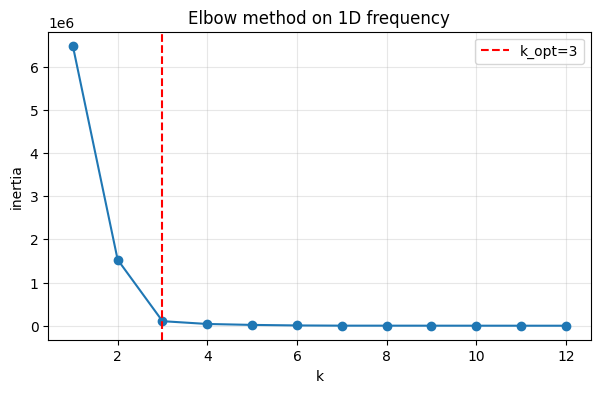

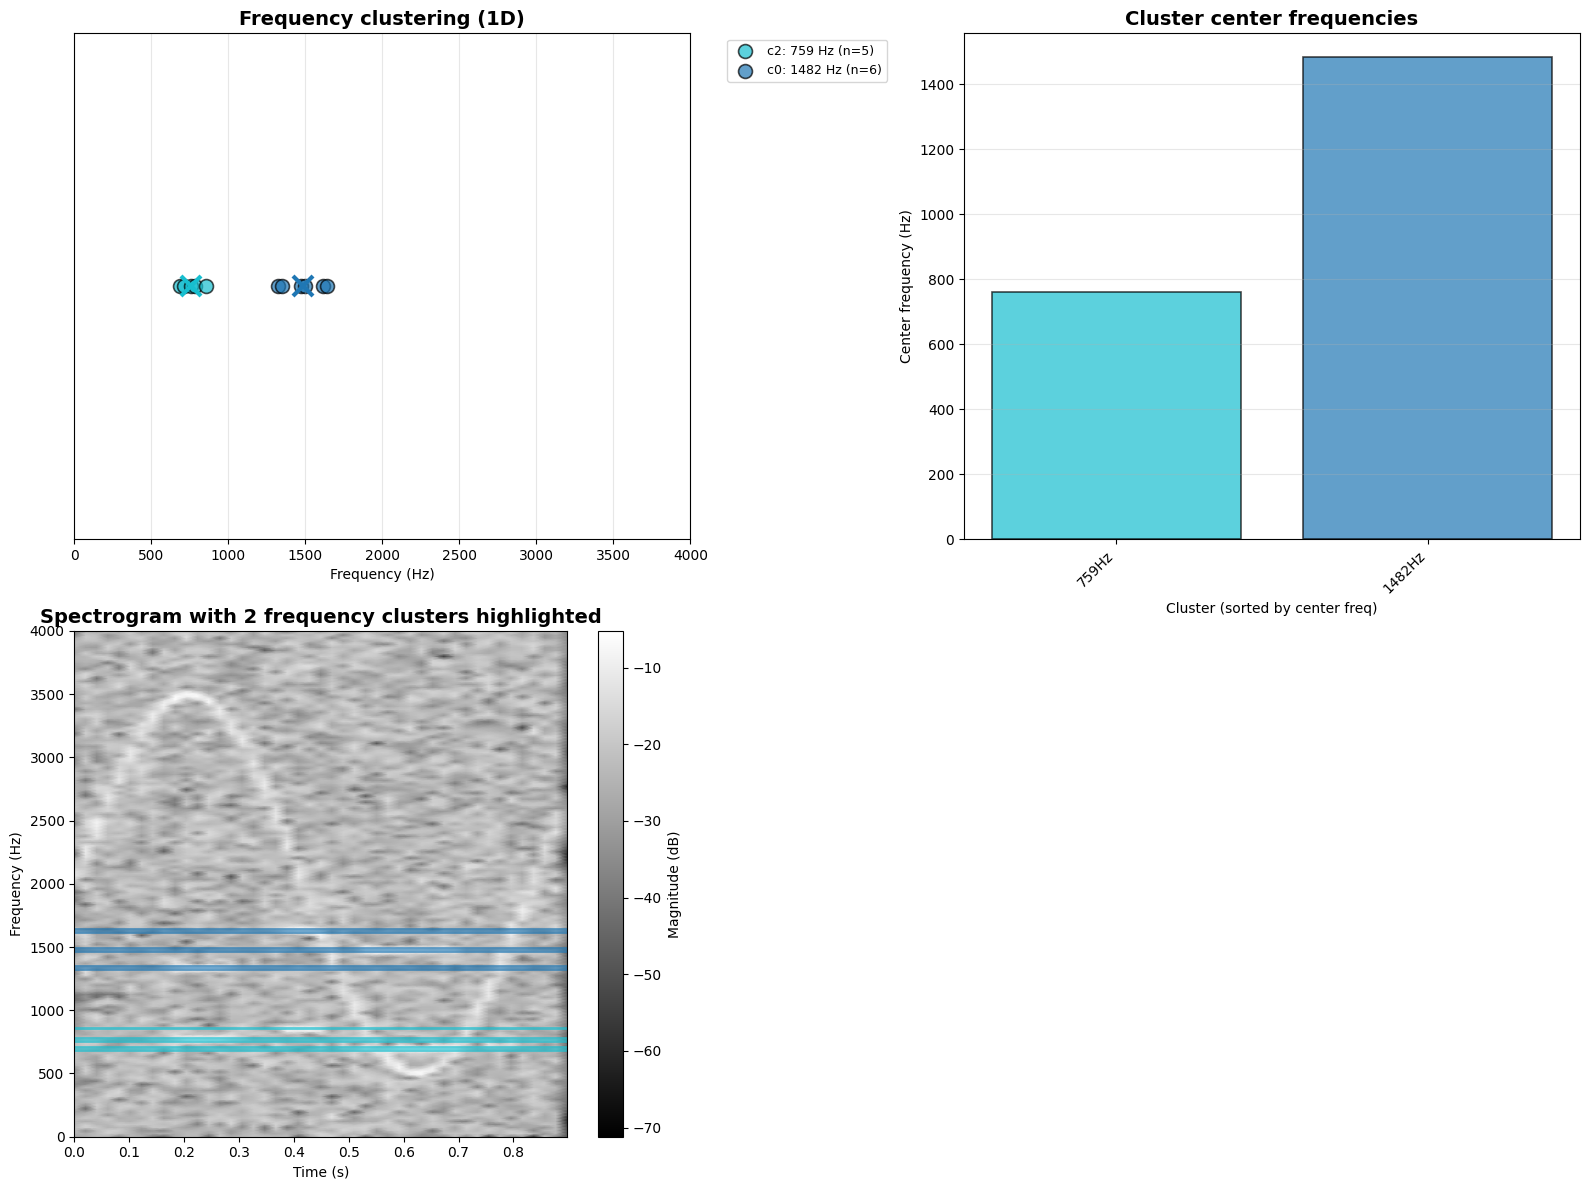

In [78]:
# Cluster high-energy frequency bins in frequency space only (after bi-clustering)
# Second-stage clustering to group high-energy bins into DTMF-like bands.
# We estimate k with an elbow method on 1D frequency only.

high_energy_freqs = f[high_energy_freq_indices]
n_high_energy = len(high_energy_freq_indices)

if n_high_energy < 2:
    print(f"Warning: only {n_high_energy} high-energy bins; skipping frequency clustering")
    major_freq_clusters = []
    freq_cluster_labels = None
    k_opt = 0
else:
    # 1D clustering features: frequency only
    freq_features = high_energy_freqs.reshape(-1, 1)

    # elbow: we scan candidate k values and pick the knee (max distance to line)
    k_max = min(12, n_high_energy)
    k_candidates = list(range(1, k_max + 1))
    inertias = []
    for k in k_candidates:
        km = KMeans(n_clusters=k, random_state=0, n_init=10)
        km.fit(freq_features)
        inertias.append(float(km.inertia_))

    if len(inertias) == 1:
        k_opt = 1
    else:
        ks = np.array(k_candidates, dtype=float)
        ys = np.array(inertias, dtype=float)
        # we normalize to [0,1] for numerical stability
        ks_n = (ks - ks.min()) / (ks.max() - ks.min() + 1e-12)
        ys_n = (ys - ys.min()) / (ys.max() - ys.min() + 1e-12)
        # we compute distance to the line between endpoints
        p1 = np.array([ks_n[0], ys_n[0]])
        p2 = np.array([ks_n[-1], ys_n[-1]])
        v = p2 - p1
        v_norm = np.linalg.norm(v) + 1e-12
        distances = []
        for xi, yi in zip(ks_n, ys_n):
            p = np.array([xi, yi])
            # distance from point to line
            dist = abs(np.cross(v, p - p1)) / v_norm
            distances.append(float(dist))
        k_opt = int(k_candidates[int(np.argmax(distances))])

    print(f"Elbow candidates k={k_candidates}")
    print(f"Elbow inertias={np.round(inertias, 3).tolist()}")
    print(f"Selected k_opt={k_opt}")

    # fit final clustering
    kmeans = KMeans(n_clusters=k_opt, random_state=0, n_init=10)
    freq_cluster_labels = kmeans.fit_predict(freq_features)

    # build cluster data
    major_freq_clusters = []
    for cluster_id in range(k_opt):
        mask = freq_cluster_labels == cluster_id
        cluster_freq_indices = high_energy_freq_indices[mask]
        cluster_freqs = high_energy_freqs[mask]
        major_freq_clusters.append({
            'cluster_id': cluster_id,
            'center_freq': np.mean(cluster_freqs) if len(cluster_freqs) > 0 else 0.0,
            'freq_indices': cluster_freq_indices,
            'freqs': cluster_freqs,
        })

# optionally filter by wide DTMF margin if desired
dtmf_freq_range = (400, 2000)
major_freq_clusters = [c for c in major_freq_clusters if dtmf_freq_range[0] <= c['center_freq'] <= dtmf_freq_range[1]]

# sort by center frequency
major_freq_clusters.sort(key=lambda c: c['center_freq'])

print(f"Number of major frequency clusters: {len(major_freq_clusters)}")
for i, c in enumerate(major_freq_clusters):
    print(f"Cluster {i}: center={c['center_freq']:.1f} Hz, n_bins={len(c['freq_indices'])}")

# elbow plot
if n_high_energy >= 2:
    plt.figure(figsize=(7, 4))
    plt.plot(k_candidates, inertias, marker='o')
    plt.axvline(k_opt, color='red', linestyle='--', label=f'k_opt={k_opt}')
    plt.title('Elbow method on 1D frequency')
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

n_clusters = len(major_freq_clusters)
k_color = max(1, (k_opt if n_high_energy >= 2 else 1))
colors_clusters = plt.cm.tab10(np.linspace(0, 1, k_color))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1: frequency scatter
if (freq_cluster_labels is not None) and (n_clusters > 0):
    for cluster in major_freq_clusters:
        cid = int(cluster['cluster_id'])
        axes[0, 0].scatter(cluster['freqs'], np.zeros_like(cluster['freqs']),
                           c=[colors_clusters[cid % len(colors_clusters)]], s=100, alpha=0.7,
                           edgecolors='black', linewidths=1.2,
                           label=f"c{cid}: {cluster['center_freq']:.0f} Hz (n={len(cluster['freq_indices'])})")
        axes[0, 0].plot(cluster['center_freq'], 0,
                        'x', color=colors_clusters[cid % len(colors_clusters)], markersize=14, markeredgewidth=3)
else:
    axes[0, 0].text(0.5, 0.5, 'no clusters to plot', ha='center', va='center', transform=axes[0, 0].transAxes)

axes[0, 0].set_title('Frequency clustering (1D)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_yticks([])
axes[0, 0].set_xlim([0, 4000])
axes[0, 0].grid(True, alpha=0.3)
if n_clusters > 0:
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# plot 2: bar chart of cluster centers
if n_clusters > 0:
    cluster_centers_freq = [c['center_freq'] for c in major_freq_clusters]
    bars = axes[0, 1].bar(range(n_clusters), cluster_centers_freq,
                          color=[colors_clusters[int(c['cluster_id']) % len(colors_clusters)] for c in major_freq_clusters],
                          alpha=0.7, edgecolor='black', linewidth=1.2)
    axes[0, 1].set_title('Cluster center frequencies', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Cluster (sorted by center freq)')
    axes[0, 1].set_ylabel('Center frequency (Hz)')
    axes[0, 1].set_xticks(range(n_clusters))
    axes[0, 1].set_xticklabels([f"{c:.0f}Hz" for c in cluster_centers_freq], rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
else:
    axes[0, 1].axis('off')

# plot 3: spectrogram with clustered lines highlighted
spectrogram = np.abs(Zxx)
im = axes[1, 0].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), shading='gouraud', cmap='gray')
if n_clusters > 0:
    for cluster in major_freq_clusters:
        cid = int(cluster['cluster_id'])
        for idx in cluster['freq_indices']:
            axes[1, 0].axhline(y=f[idx], color=colors_clusters[cid % len(colors_clusters)], linewidth=2.0, alpha=0.7)

axes[1, 0].set_title(f'Spectrogram with {n_clusters} frequency clusters highlighted', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Frequency (Hz)')
axes[1, 0].set_ylim([0, 4000])
plt.colorbar(im, ax=axes[1, 0], label='Magnitude (dB)')

# plot 4: dummy/off
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


Top out-of-band freqs (by energy):
  f=3479.0 Hz, energy=9.682e-01

Hierarchical split uses band-limited bins: n=11 (from total 12)

Coarse split (k=2) centers (in-band): [1482.2, 759.5] Hz
Low group: n=5, mean=759.5 Hz
High group: n=6, mean=1482.2 Hz


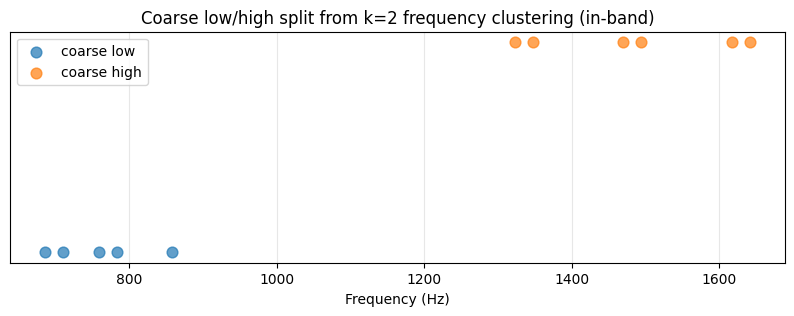


Hierarchical elbow inside groups
Low group: n=5, k_low=3
High group: n=6, k_high=3


/tmp/ipykernel_171730/1897620849.py:30: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = abs(np.cross(v, p - p1)) / v_norm
/tmp/ipykernel_171730/1897620849.py:30: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = abs(np.cross(v, p - p1)) / v_norm


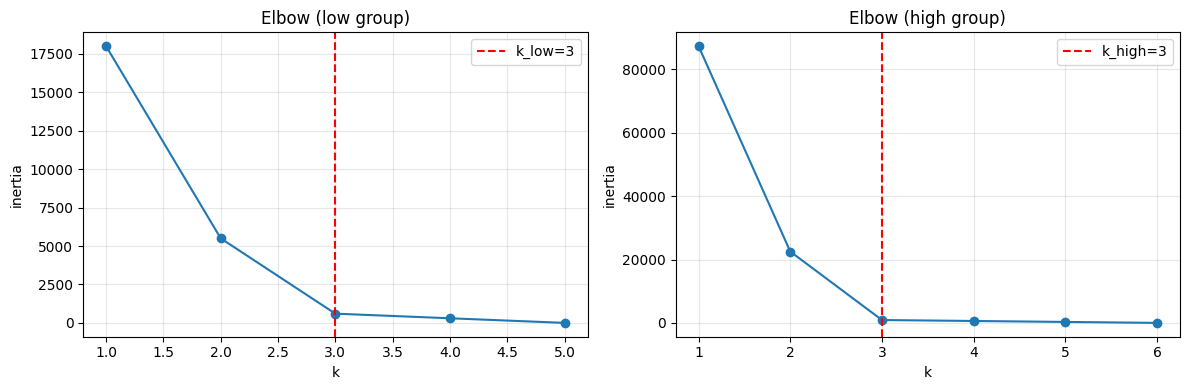

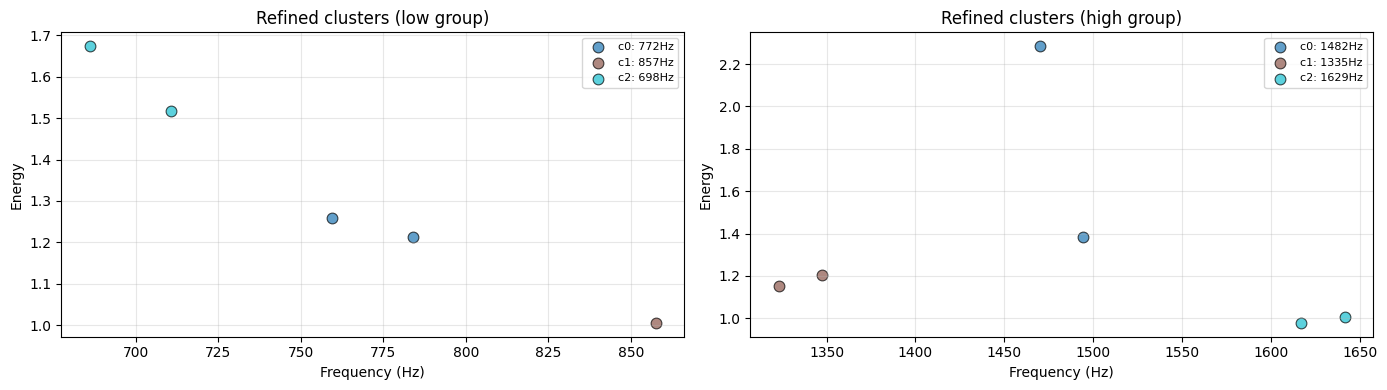


Refined clusters after low/high elbow: 6
Cluster 0: band=low, center=698.2 Hz, n_bins=2
Cluster 1: band=low, center=771.7 Hz, n_bins=2
Cluster 2: band=low, center=857.5 Hz, n_bins=1
Cluster 3: band=high, center=1335.2 Hz, n_bins=2
Cluster 4: band=high, center=1482.2 Hz, n_bins=2
Cluster 5: band=high, center=1629.2 Hz, n_bins=2


In [79]:
# hierarchical elbow clustering: we split low/high then recluster each group
# we do a coarse k=2 split in frequency, but only inside a wide DTMF band to avoid outliers

def elbow_kmeans_1d(freqs_1d, k_max=12, random_state=0, n_init=10):
    freqs_1d = np.asarray(freqs_1d, dtype=float).reshape(-1, 1)
    n = int(freqs_1d.shape[0])
    if n < 2:
        return 0, None, [], []
    k_max_eff = int(min(max(1, k_max), n))
    k_candidates = list(range(1, k_max_eff + 1))
    inertias = []
    for k in k_candidates:
        km = KMeans(n_clusters=k, random_state=int(random_state), n_init=int(n_init))
        km.fit(freqs_1d)
        inertias.append(float(km.inertia_))
    if len(inertias) == 1:
        k_opt = 1
    else:
        ks = np.array(k_candidates, dtype=float)
        ys = np.array(inertias, dtype=float)
        ks_n = (ks - ks.min()) / (ks.max() - ks.min() + 1e-12)
        ys_n = (ys - ys.min()) / (ys.max() - ys.min() + 1e-12)
        p1 = np.array([ks_n[0], ys_n[0]])
        p2 = np.array([ks_n[-1], ys_n[-1]])
        v = p2 - p1
        v_norm = np.linalg.norm(v) + 1e-12
        distances = []
        for xi, yi in zip(ks_n, ys_n):
            p = np.array([xi, yi])
            dist = abs(np.cross(v, p - p1)) / v_norm
            distances.append(float(dist))
        k_opt = int(k_candidates[int(np.argmax(distances))])
    km_final = KMeans(n_clusters=int(k_opt), random_state=int(random_state), n_init=int(n_init))
    labels = km_final.fit_predict(freqs_1d)
    return int(k_opt), labels, k_candidates, inertias

# we take the high-energy bins from cell 2
high_energy_freqs_all = f[high_energy_freq_indices]
high_energy_energies_all = energy_per_freq[high_energy_freq_indices]
n_high_energy_all = len(high_energy_freq_indices)

# we restrict the hierarchical split to a wide DTMF band to avoid a single noisy outlier bin
dtmf_freq_range = (400.0, 2000.0)
band_mask = (high_energy_freqs_all >= dtmf_freq_range[0]) & (high_energy_freqs_all <= dtmf_freq_range[1])
out_mask = ~band_mask

if np.any(out_mask):
    out_freqs = high_energy_freqs_all[out_mask]
    out_energies = high_energy_energies_all[out_mask]
    # we print the largest-energy out-of-band bins for debugging
    order = np.argsort(out_energies)[::-1]
    top_k = min(10, len(order))
    print(f"Warning: {int(np.sum(out_mask))}/{n_high_energy_all} high-energy bins are outside {dtmf_freq_range} Hz")
    print('Top out-of-band freqs (by energy):')
    for i in range(top_k):
        fi = float(out_freqs[order[i]])
        ei = float(out_energies[order[i]])
        print(f"  f={fi:.1f} Hz, energy={ei:.3e}")

high_energy_freqs = high_energy_freqs_all[band_mask]
high_energy_energies = high_energy_energies_all[band_mask]
high_energy_indices = high_energy_freq_indices[band_mask]
n_high_energy = len(high_energy_indices)

print(f"\nHierarchical split uses band-limited bins: n={n_high_energy} (from total {n_high_energy_all})")

if n_high_energy < 2:
    print(f"Warning: only {n_high_energy} in-band bins; skipping hierarchical clustering")
    major_freq_clusters = []
else:
    # coarse split: k=2 on in-band frequency only
    km_2 = KMeans(n_clusters=2, random_state=0, n_init=10)
    coarse_labels = km_2.fit_predict(high_energy_freqs.reshape(-1, 1))
    coarse_centers = km_2.cluster_centers_.flatten()
    low_coarse_id = int(np.argmin(coarse_centers))
    high_coarse_id = int(np.argmax(coarse_centers))

    low_mask = coarse_labels == low_coarse_id
    high_mask = coarse_labels == high_coarse_id

    low_freqs = high_energy_freqs[low_mask]
    low_energies = high_energy_energies[low_mask]
    low_indices = high_energy_indices[low_mask]

    high_freqs = high_energy_freqs[high_mask]
    high_energies = high_energy_energies[high_mask]
    high_indices = high_energy_indices[high_mask]

    print(f"\nCoarse split (k=2) centers (in-band): {np.round(coarse_centers, 1).tolist()} Hz")
    print(f"Low group: n={len(low_freqs)}, mean={float(np.mean(low_freqs)) if len(low_freqs) else float('nan'):.1f} Hz")
    print(f"High group: n={len(high_freqs)}, mean={float(np.mean(high_freqs)) if len(high_freqs) else float('nan'):.1f} Hz")

    plt.figure(figsize=(10, 3))
    plt.scatter(low_freqs, np.zeros_like(low_freqs), s=60, alpha=0.7, label='coarse low')
    plt.scatter(high_freqs, np.zeros_like(high_freqs) + 0.05, s=60, alpha=0.7, label='coarse high')
    plt.yticks([])
    plt.xlabel('Frequency (Hz)')
    plt.title('Coarse low/high split from k=2 frequency clustering (in-band)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    k_low, low_labels, low_k_candidates, low_inertias = elbow_kmeans_1d(low_freqs, k_max=8)
    k_high, high_labels, high_k_candidates, high_inertias = elbow_kmeans_1d(high_freqs, k_max=8)

    print(f"\nHierarchical elbow inside groups")
    print(f"Low group: n={len(low_freqs)}, k_low={k_low}")
    print(f"High group: n={len(high_freqs)}, k_high={k_high}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    if len(low_inertias) > 0:
        axes[0].plot(low_k_candidates, low_inertias, marker='o')
        axes[0].axvline(k_low, color='red', linestyle='--', label=f'k_low={k_low}')
        axes[0].set_title('Elbow (low group)')
        axes[0].set_xlabel('k')
        axes[0].set_ylabel('inertia')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
    else:
        axes[0].axis('off')

    if len(high_inertias) > 0:
        axes[1].plot(high_k_candidates, high_inertias, marker='o')
        axes[1].axvline(k_high, color='red', linestyle='--', label=f'k_high={k_high}')
        axes[1].set_title('Elbow (high group)')
        axes[1].set_xlabel('k')
        axes[1].set_ylabel('inertia')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    if (low_labels is not None) and (k_low > 0):
        colors_low = plt.cm.tab10(np.linspace(0, 1, int(k_low)))
        for cid in range(int(k_low)):
            mask = low_labels == cid
            axes[0].scatter(low_freqs[mask], low_energies[mask], s=60, alpha=0.7,
                            color=colors_low[cid], edgecolors='black', linewidths=0.8,
                            label=f'c{cid}: {float(np.mean(low_freqs[mask])):.0f}Hz')
        axes[0].set_title('Refined clusters (low group)')
        axes[0].set_xlabel('Frequency (Hz)')
        axes[0].set_ylabel('Energy')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(fontsize=8)
    else:
        axes[0].axis('off')

    if (high_labels is not None) and (k_high > 0):
        colors_high = plt.cm.tab10(np.linspace(0, 1, int(k_high)))
        for cid in range(int(k_high)):
            mask = high_labels == cid
            axes[1].scatter(high_freqs[mask], high_energies[mask], s=60, alpha=0.7,
                            color=colors_high[cid], edgecolors='black', linewidths=0.8,
                            label=f'c{cid}: {float(np.mean(high_freqs[mask])):.0f}Hz')
        axes[1].set_title('Refined clusters (high group)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('Energy')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend(fontsize=8)
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    major_freq_clusters = []
    cluster_id_counter = 0

    if (low_labels is not None) and (k_low > 0):
        for cid in range(int(k_low)):
            mask = low_labels == cid
            cfreqs = low_freqs[mask]
            cenergies = low_energies[mask]
            cidx = low_indices[mask]
            if len(cfreqs) == 0:
                continue
            major_freq_clusters.append({
                'cluster_id': cluster_id_counter,
                'band': 'low',
                'center_freq': float(np.mean(cfreqs)),
                'center_energy': float(np.mean(cenergies)) if len(cenergies) > 0 else 0.0,
                'freq_indices': cidx,
                'freqs': cfreqs,
                'energies': cenergies,
            })
            cluster_id_counter += 1

    if (high_labels is not None) and (k_high > 0):
        for cid in range(int(k_high)):
            mask = high_labels == cid
            cfreqs = high_freqs[mask]
            cenergies = high_energies[mask]
            cidx = high_indices[mask]
            if len(cfreqs) == 0:
                continue
            major_freq_clusters.append({
                'cluster_id': cluster_id_counter,
                'band': 'high',
                'center_freq': float(np.mean(cfreqs)),
                'center_energy': float(np.mean(cenergies)) if len(cenergies) > 0 else 0.0,
                'freq_indices': cidx,
                'freqs': cfreqs,
                'energies': cenergies,
            })
            cluster_id_counter += 1

    major_freq_clusters.sort(key=lambda c: c['center_freq'])

    print(f"\nRefined clusters after low/high elbow: {len(major_freq_clusters)}")
    for i, c in enumerate(major_freq_clusters):
        print(f"Cluster {i}: band={c['band']}, center={c['center_freq']:.1f} Hz, n_bins={len(c['freq_indices'])}")


Cluster 2 (center=698.2 Hz, n_bins=2):
  Selected freq: 686.0 Hz with 2 CPs
Cluster 0 (center=771.7 Hz, n_bins=2):
  Selected freq: 759.5 Hz with 2 CPs
Cluster 1 (center=857.5 Hz, n_bins=1):
  Selected freq: 857.5 Hz with 2 CPs
Cluster 4 (center=1335.2 Hz, n_bins=2):
  Selected freq: 1323.0 Hz with 2 CPs
Cluster 3 (center=1482.2 Hz, n_bins=2):
  Selected freq: 1470.0 Hz with 2 CPs
Cluster 5 (center=1629.2 Hz, n_bins=2):
  Selected freq: 1617.0 Hz with 2 CPs

Total unique changepoints across all clusters: 8
Changepoint positions: [4500, 6300, 8550, 9900, 10350, 11700, 15300, 15750]...


/tmp/ipykernel_171730/3811300355.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


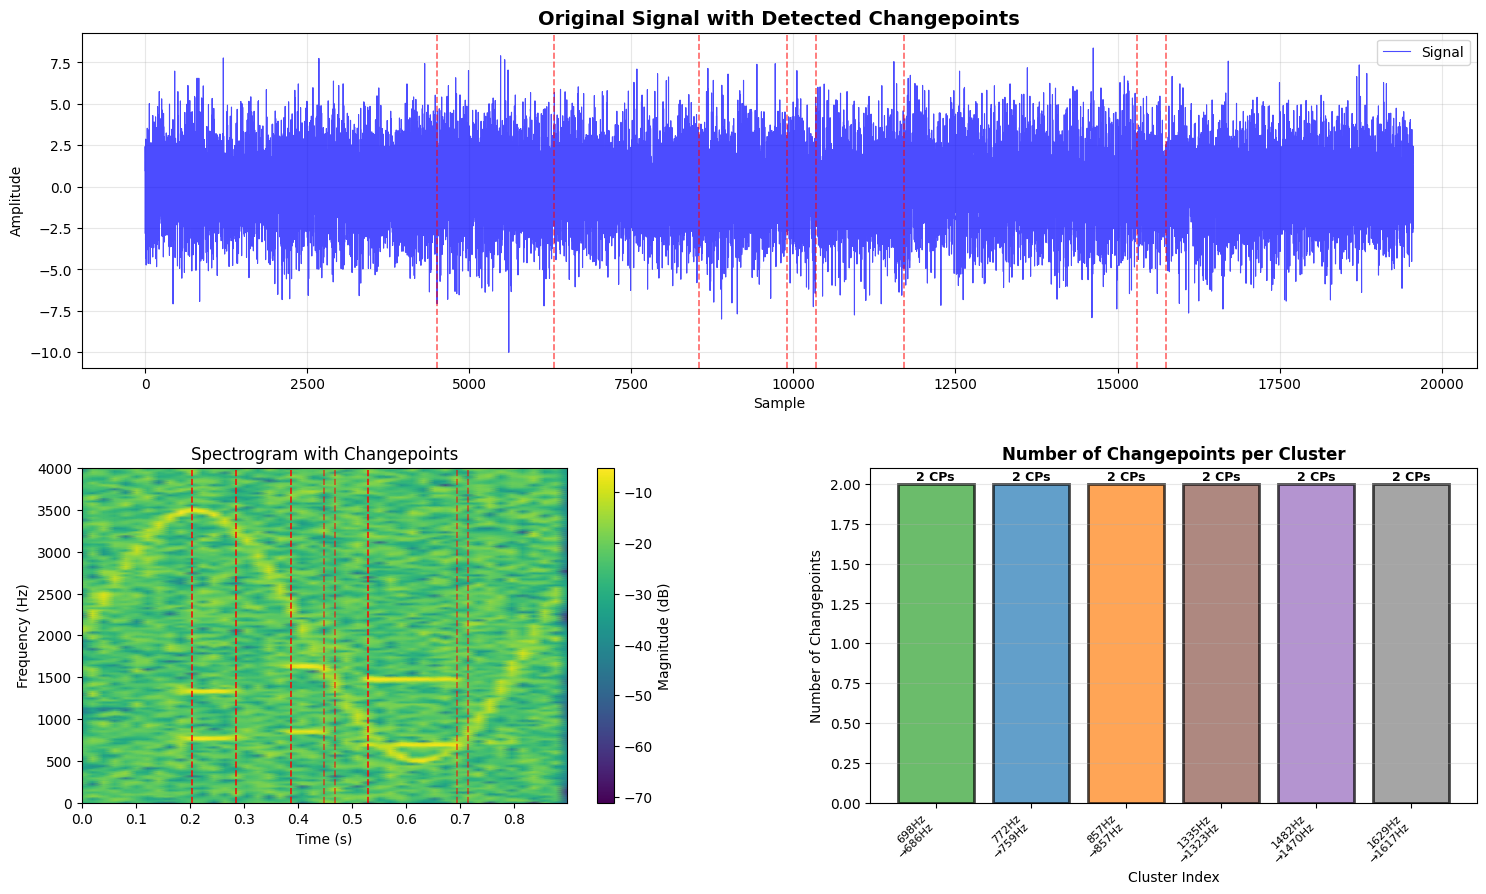

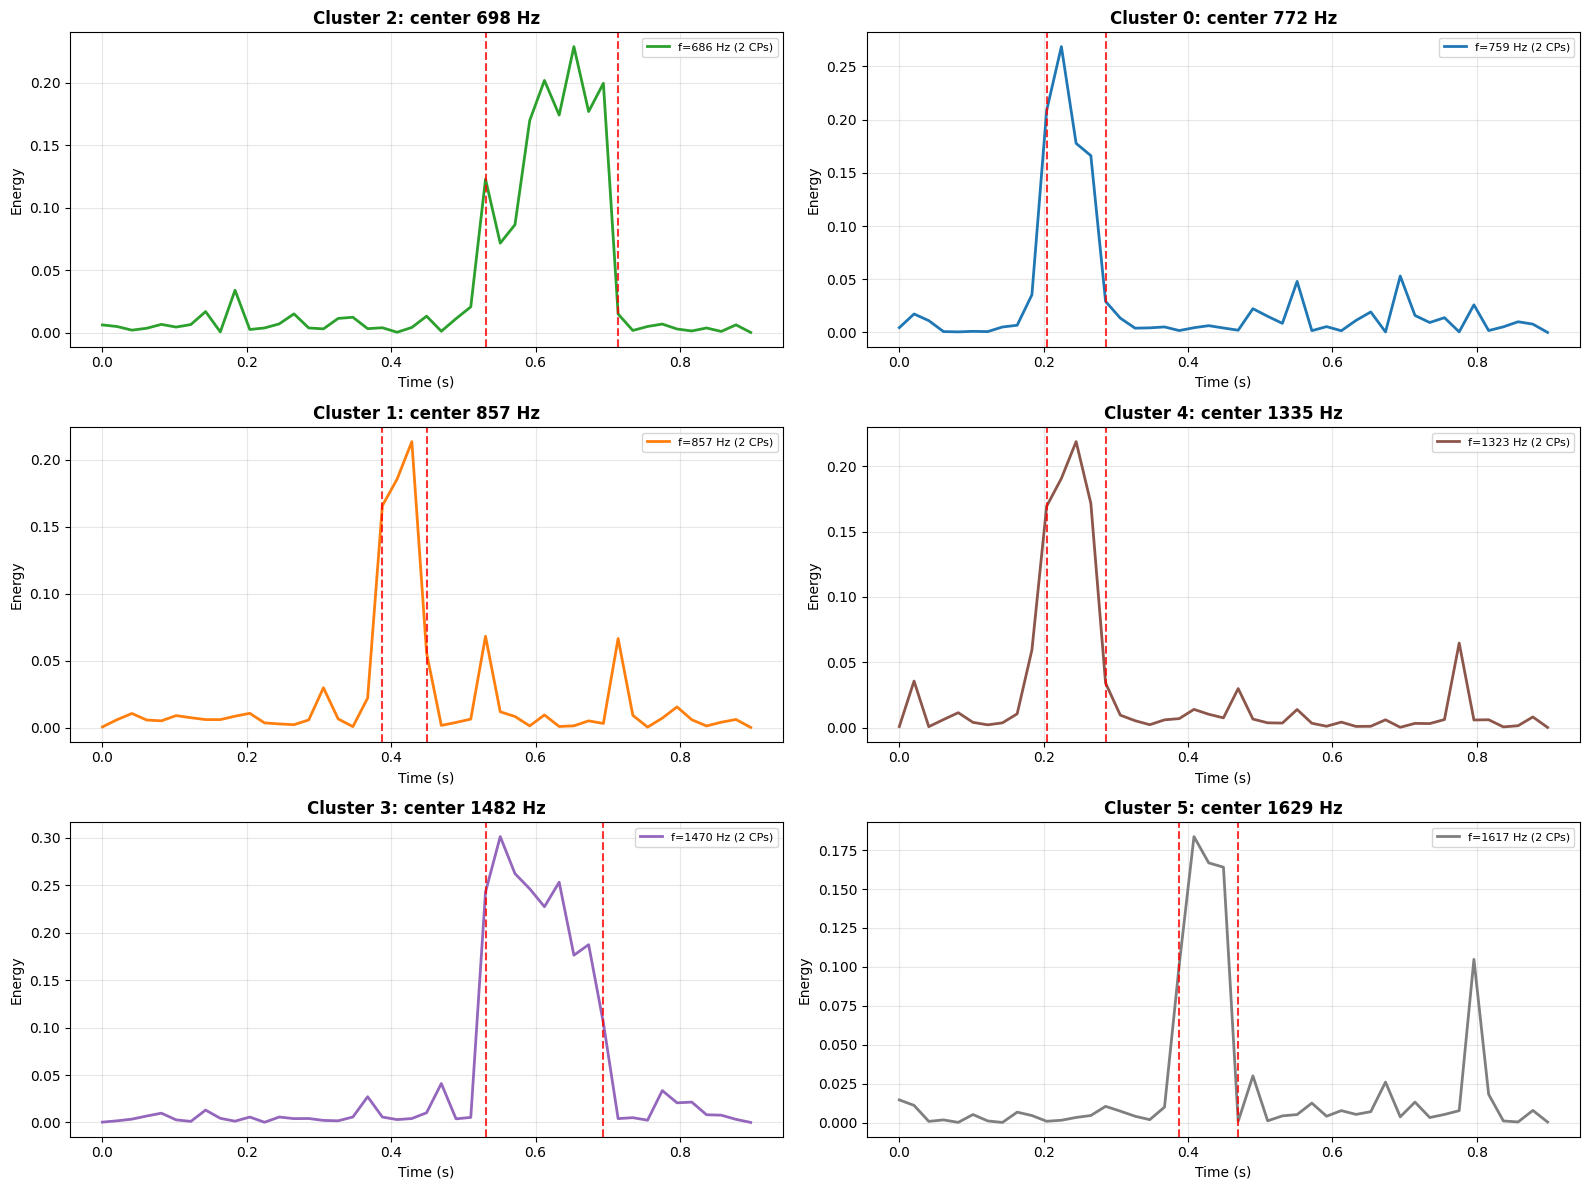

In [95]:
# Cell 4: Changepoint detection on each frequency cluster
# we run changepoint detection only on ONE frequency per cluster
# (we pick the frequency bin closest to the cluster center frequency)

t_max = len(t)
all_changepoints = []
frame_step = window_length - overlap

for cluster in major_freq_clusters:
    freq_indices = np.array(cluster['freq_indices'], dtype=int)
    if len(freq_indices) == 0:
        continue

    # we choose the bin in this cluster closest to its center frequency
    cluster_f = f[freq_indices]
    center_f = float(cluster.get('center_freq', float(np.mean(cluster_f))))
    rel_idx = int(np.argmin(np.abs(cluster_f - center_f)))
    selected_freq_idx = int(freq_indices[rel_idx])
    selected_freq = float(f[selected_freq_idx])

    freq_energy = np.abs(Zxx[selected_freq_idx, :])**2

    sigma_est = np.std(freq_energy)
    pen_bic = 2 * sigma_est**2 * np.log(t_max)

    algo = rpt.Pelt(model="l2", jump=1)
    predicted_bkps = algo.fit_predict(freq_energy, pen=pen_bic)

    signal_bkps = [min(int(idx * frame_step), len(signal)) for idx in predicted_bkps[:-1]]

    all_changepoints.append({
        'cluster_id': int(cluster['cluster_id']),
        'center_freq': float(cluster.get('center_freq', selected_freq)),
        'selected_freq': selected_freq,
        'selected_freq_idx': selected_freq_idx,
        'changepoints': signal_bkps,
        'frame_bkps': predicted_bkps[:-1],
        'energy_signal': freq_energy,
        'n_cps': int(len(signal_bkps)),
    })

    print(f"Cluster {int(cluster['cluster_id'])} (center={float(cluster.get('center_freq', selected_freq)):.1f} Hz, n_bins={len(freq_indices)}):")
    print(f"  Selected freq: {selected_freq:.1f} Hz with {len(signal_bkps)} CPs")

all_bkps = sorted(set([bp for cp_dict in all_changepoints for bp in cp_dict['changepoints']]))
print(f"\nTotal unique changepoints across all clusters: {len(all_bkps)}")
print(f"Changepoint positions: {all_bkps[:10]}...")

# main overview plots (signal + spectrogram + cp count)
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(signal, 'b-', linewidth=0.8, alpha=0.7, label='Signal')
for bp in all_bkps:
    ax1.axvline(x=bp, color='red', linestyle='--', linewidth=1.2, alpha=0.6)
ax1.set_title('Original Signal with Detected Changepoints', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 0])
spectrogram = np.abs(Zxx)
im = ax6.pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), shading='gouraud', cmap='viridis')
for cp_dict in all_changepoints:
    for frame_bp in cp_dict['frame_bkps']:
        if frame_bp < len(t):
            ax6.axvline(x=t[frame_bp], color='red', linestyle='--', linewidth=1.2, alpha=0.6)
ax6.set_title('Spectrogram with Changepoints')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Frequency (Hz)')
ax6.set_ylim([0, 4000])
plt.colorbar(im, ax=ax6, label='Magnitude (dB)')

ax7 = fig.add_subplot(gs[1, 1])
colors_8 = plt.cm.tab10(np.linspace(0, 1, 8))
cluster_ids = [cp['cluster_id'] for cp in all_changepoints]
n_changepoints = [cp['n_cps'] for cp in all_changepoints]
bars = ax7.bar(range(len(all_changepoints)), n_changepoints,
              color=[colors_8[int(i) % 8] for i in cluster_ids], alpha=0.7, edgecolor='black', linewidth=2)
ax7.set_title('Number of Changepoints per Cluster', fontweight='bold')
ax7.set_xlabel('Cluster Index')
ax7.set_ylabel('Number of Changepoints')
ax7.set_xticks(range(len(all_changepoints)))
ax7.set_xticklabels([f"{cp['center_freq']:.0f}Hz\n→{cp['selected_freq']:.0f}Hz" for cp in all_changepoints], rotation=45, ha='right', fontsize=8)
ax7.grid(True, alpha=0.3, axis='y')
for bar, n_cp in zip(bars, n_changepoints):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height, f"{n_cp} CPs", ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# energy+CP plot for ALL clusters (not only first 4)
n_clusters = len(all_changepoints)
n_rows = (n_clusters + 1) // 2
figE, axesE = plt.subplots(n_rows, 2, figsize=(16, 4*n_rows))
if n_rows == 1:
    axesE = axesE.reshape(1, -1)
axesE = axesE.flatten()

for idx, cp_dict in enumerate(all_changepoints):
    ax = axesE[idx]
    cid = int(cp_dict['cluster_id'])
    ax.plot(t, cp_dict['energy_signal'], color=colors_8[cid % 8], linewidth=2.0,
            label=f"f={cp_dict['selected_freq']:.0f} Hz ({cp_dict['n_cps']} CPs)")
    for frame_bp in cp_dict['frame_bkps']:
        if frame_bp < len(t):
            ax.axvline(x=t[frame_bp], color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.set_title(f"Cluster {cp_dict['cluster_id']}: center {cp_dict['center_freq']:.0f} Hz", fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Energy')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

for idx in range(n_clusters, len(axesE)):
    axesE[idx].axis('off')

plt.tight_layout()
plt.show()


Ground truth (y_train[0]) = 5C3 (N=3)
Coarse low/high centers (Hz): [1470.0, 767.7]

Low clusters (3):
  cluster 2: f=686.0 Hz, cps=[11700, 15750]
  cluster 0: f=759.5 Hz, cps=[4500, 6300]
  cluster 1: f=857.5 Hz, cps=[8550, 9900]

High clusters (3):
  cluster 4: f=1323.0 Hz, cps=[4500, 6300]
  cluster 3: f=1470.0 Hz, cps=[11700, 15300]
  cluster 5: f=1617.0 Hz, cps=[8550, 10350]

Low intervals (ALL across clusters): 9
  001. cid=0, f=759.5Hz, t=[0.000,0.204]s, dur=0.204s, meanE=2.657e-02, totalE=2.922e-01
  002. cid=0, f=759.5Hz, t=[0.204,0.286]s, dur=0.082s, meanE=1.700e-01, totalE=8.502e-01
  003. cid=0, f=759.5Hz, t=[0.286,0.887]s, dur=0.601s, meanE=1.177e-02, totalE=3.531e-01
  004. cid=1, f=857.5Hz, t=[0.000,0.388]s, dur=0.388s, meanE=1.569e-02, totalE=3.137e-01
  005. cid=1, f=857.5Hz, t=[0.388,0.449]s, dur=0.061s, meanE=1.553e-01, totalE=6.211e-01
  006. cid=1, f=857.5Hz, t=[0.449,0.887]s, dur=0.438s, meanE=1.328e-02, totalE=2.922e-01
  007. cid=2, f=686.0Hz, t=[0.000,0.531]s, 

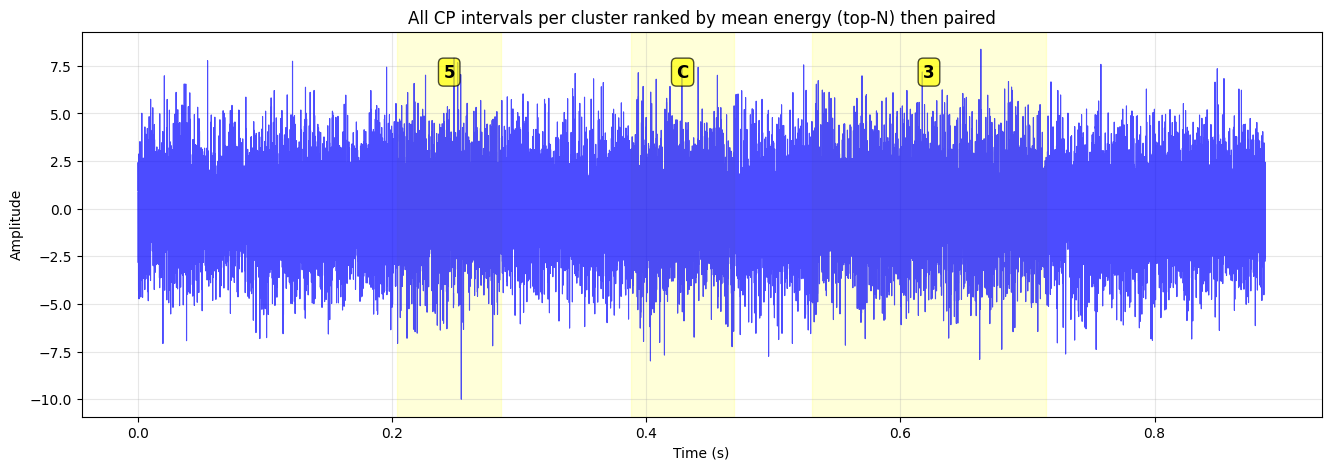

In [97]:
# Cell 5: build ALL CP intervals per cluster, rank by mean energy, keep top-N, then pair
# we build intervals from each cluster changepoints (per-cluster), compute mean energy in each interval,
# aggregate all intervals in low group and all intervals in high group, sort by mean energy,
# keep the N strongest non-overlapping intervals, order them by start time, pair by index, and match y_train

dtmf_low_freqs = [697, 770, 852, 941]  # Hz
dtmf_high_freqs = [1209, 1336, 1477, 1633]  # Hz
dtmf_symbols = [
    ['1', '2', '3', 'A'],
    ['4', '5', '6', 'B'],
    ['7', '8', '9', 'C'],
    ['*', '0', '#', 'D'],
]

def freq_to_dtmf_index(freq, freq_list, tol_hz=50.0):
    distances = np.abs(np.array(freq_list, dtype=float) - float(freq))
    min_idx = int(np.argmin(distances))
    min_dist = float(distances[min_idx])
    if min_dist <= float(tol_hz):
        return min_idx, min_dist
    return None, min_dist

def intervals_from_changepoints(changepoints, start_sample, end_sample):
    cps = [int(cp) for cp in changepoints if cp is not None]
    cps = [cp for cp in cps if int(start_sample) < cp < int(end_sample)]
    cps_sorted = sorted(set(cps))
    boundaries = [int(start_sample)] + cps_sorted + [int(end_sample)]
    return [(boundaries[i], boundaries[i + 1]) for i in range(len(boundaries) - 1) if boundaries[i] < boundaries[i + 1]]

def segment_energy_stats(energy_frames, start_sample, end_sample, frame_step):
    start_frame = max(0, int(start_sample / frame_step))
    end_frame = min(len(energy_frames), int(end_sample / frame_step) + 1)
    if start_frame >= end_frame:
        return 0.0, 0.0, 0
    seg = energy_frames[start_frame:end_frame]
    if len(seg) == 0:
        return 0.0, 0.0, 0
    mean_e = float(np.mean(seg))
    n_frames = int(len(seg))
    total_e = float(mean_e * n_frames)
    return mean_e, total_e, n_frames

def build_all_intervals_for_group(cp_dicts, frame_step, min_duration_samples=100):
    intervals = []
    for cp in cp_dicts:
        segs = intervals_from_changepoints(cp['changepoints'], 0, len(signal))
        for s, e in segs:
            if (e - s) < int(min_duration_samples):
                continue
            mean_e, total_e, n_frames = segment_energy_stats(cp['energy_signal'], s, e, frame_step)
            intervals.append({
                'cluster_id': int(cp['cluster_id']),
                'freq': float(cp['selected_freq']),
                'start_time': int(s),
                'end_time': int(e),
                'duration_samples': int(e - s),
                'duration_seconds': float((e - s) / FS),
                'mean_energy': float(mean_e),
                'total_energy': float(total_e),
                'n_frames': int(n_frames),
            })
    return intervals

def select_topN_non_overlapping(intervals, N, score_key='mean_energy'):
    # we sort by score desc, then keep first N non-overlapping intervals
    ranked = sorted(intervals, key=lambda x: x[score_key], reverse=True)
    selected = []
    for itv in ranked:
        overlap = False
        for s in selected:
            if not (itv['end_time'] <= s['start_time'] or itv['start_time'] >= s['end_time']):
                overlap = True
                break
        if not overlap:
            selected.append(itv)
        if len(selected) >= int(max(1, N)):
            break
    selected_time = sorted(selected, key=lambda x: x['start_time'])
    return ranked, selected_time

# ground truth defines N
ground_truth = y_train[0]
gt_seq = ground_truth if isinstance(ground_truth, str) else ''.join(list(ground_truth))
N = int(len(gt_seq))
print(f"Ground truth (y_train[0]) = {gt_seq} (N={N})")

# split clusters into low/high using coarse k=2 on selected_freq
selected_freqs = np.array([float(cp['selected_freq']) for cp in all_changepoints], dtype=float)
km2 = KMeans(n_clusters=2, random_state=0, n_init=10)
coarse_labels = km2.fit_predict(selected_freqs.reshape(-1, 1))
centers = km2.cluster_centers_.flatten()
low_id = int(np.argmin(centers))
high_id = int(np.argmax(centers))
low_freq_clusters = [cp for cp, lab in zip(all_changepoints, coarse_labels) if int(lab) == low_id]
high_freq_clusters = [cp for cp, lab in zip(all_changepoints, coarse_labels) if int(lab) == high_id]
print(f"Coarse low/high centers (Hz): {np.round(centers, 1).tolist()}")

print(f"\nLow clusters ({len(low_freq_clusters)}):")
for cp in sorted(low_freq_clusters, key=lambda x: x['selected_freq']):
    print(f"  cluster {int(cp['cluster_id'])}: f={float(cp['selected_freq']):.1f} Hz, cps={list(map(int, cp['changepoints']))}")
print(f"\nHigh clusters ({len(high_freq_clusters)}):")
for cp in sorted(high_freq_clusters, key=lambda x: x['selected_freq']):
    print(f"  cluster {int(cp['cluster_id'])}: f={float(cp['selected_freq']):.1f} Hz, cps={list(map(int, cp['changepoints']))}")

# build ALL intervals per cluster in each group
low_all = build_all_intervals_for_group(low_freq_clusters, frame_step)
high_all = build_all_intervals_for_group(high_freq_clusters, frame_step)

print(f"\nLow intervals (ALL across clusters): {len(low_all)}")
for i, itv in enumerate(sorted(low_all, key=lambda x: (x['cluster_id'], x['start_time']))):
    print(f"  {i+1:03d}. cid={itv['cluster_id']}, f={itv['freq']:.1f}Hz, t=[{itv['start_time']/FS:.3f},{itv['end_time']/FS:.3f}]s, dur={itv['duration_seconds']:.3f}s, meanE={itv['mean_energy']:.3e}, totalE={itv['total_energy']:.3e}")

print(f"\nHigh intervals (ALL across clusters): {len(high_all)}")
for i, itv in enumerate(sorted(high_all, key=lambda x: (x['cluster_id'], x['start_time']))):
    print(f"  {i+1:03d}. cid={itv['cluster_id']}, f={itv['freq']:.1f}Hz, t=[{itv['start_time']/FS:.3f},{itv['end_time']/FS:.3f}]s, dur={itv['duration_seconds']:.3f}s, meanE={itv['mean_energy']:.3e}, totalE={itv['total_energy']:.3e}")

# rank by mean energy and keep top-N (non-overlapping), then order by start time
low_ranked, low_topN_time = select_topN_non_overlapping(low_all, N, score_key='mean_energy')
high_ranked, high_topN_time = select_topN_non_overlapping(high_all, N, score_key='mean_energy')

print(f"\nLow intervals ranked by mean energy (top {min(len(low_ranked), N)} shown):")
for i, itv in enumerate(low_ranked[:max(1, N)]):
    print(f"  r{i+1:02d}. cid={itv['cluster_id']}, f={itv['freq']:.1f}Hz, t=[{itv['start_time']/FS:.3f},{itv['end_time']/FS:.3f}]s, meanE={itv['mean_energy']:.3e}")
print(f"\nHigh intervals ranked by mean energy (top {min(len(high_ranked), N)} shown):")
for i, itv in enumerate(high_ranked[:max(1, N)]):
    print(f"  r{i+1:02d}. cid={itv['cluster_id']}, f={itv['freq']:.1f}Hz, t=[{itv['start_time']/FS:.3f},{itv['end_time']/FS:.3f}]s, meanE={itv['mean_energy']:.3e}")

print(f"\nLow top-{N} kept (time-ordered):")
for i, itv in enumerate(low_topN_time):
    print(f"  {i+1:02d}. cid={itv['cluster_id']}, f={itv['freq']:.1f}Hz, t=[{itv['start_time']/FS:.3f},{itv['end_time']/FS:.3f}]s, meanE={itv['mean_energy']:.3e}")
print(f"\nHigh top-{N} kept (time-ordered):")
for i, itv in enumerate(high_topN_time):
    print(f"  {i+1:02d}. cid={itv['cluster_id']}, f={itv['freq']:.1f}Hz, t=[{itv['start_time']/FS:.3f},{itv['end_time']/FS:.3f}]s, meanE={itv['mean_energy']:.3e}")

# pair by order id
n_pairs = min(len(low_topN_time), len(high_topN_time), N)
predicted = []
print('\nPaired by order id:')
for i in range(n_pairs):
    low_itv = low_topN_time[i]
    high_itv = high_topN_time[i]
    li, low_dist = freq_to_dtmf_index(low_itv['freq'], dtmf_low_freqs)
    hi, high_dist = freq_to_dtmf_index(high_itv['freq'], dtmf_high_freqs)
    sym = '?'
    if (li is not None) and (hi is not None):
        sym = dtmf_symbols[li][hi]
    predicted.append(sym)
    print(f"  {i+1:02d}. low(cid={low_itv['cluster_id']}, f={low_itv['freq']:.1f}Hz) + high(cid={high_itv['cluster_id']}, f={high_itv['freq']:.1f}Hz) -> sym='{sym}'")

pred_seq = ''.join(predicted)
print(f"\nPredicted sequence: {pred_seq}")
n_cmp = min(len(gt_seq), len(pred_seq))
if n_cmp > 0:
    acc = sum(1 for a, b in zip(gt_seq[:n_cmp], pred_seq[:n_cmp]) if a == b) / n_cmp
    print(f"Match accuracy on first {n_cmp} symbols: {acc:.3f}")

# visualization: show paired windows on signal
plt.figure(figsize=(16, 5))
plt.plot(np.arange(len(signal)) / FS, signal, 'b-', linewidth=0.8, alpha=0.7)
y_pos = float(np.max(signal)) * 0.8
for i in range(n_pairs):
    s = min(low_topN_time[i]['start_time'], high_topN_time[i]['start_time'])
    e = max(low_topN_time[i]['end_time'], high_topN_time[i]['end_time'])
    plt.axvspan(s/FS, e/FS, alpha=0.15, color='yellow')
    mid_t = (s + e) / (2 * FS)
    plt.text(mid_t, y_pos, predicted[i], ha='center', va='bottom', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
plt.title('All CP intervals per cluster ranked by mean energy (top-N) then paired')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.show()


## Utility functions: 

In [ ]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r    

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def is_connected(graph) -> bool:
    return graph.is_connected()

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [ ]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [ ]:
data_df["temp"] = data_df['t']- 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

# Question 5

# Question 6

# Question 7